# Technology Factors Dataset ETL

In [2]:
# data cleaning/processing imports
import pandas as pd
import numpy as np
import json
import requests

# plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

## US Aggregate Dataset

##### Extracting the Data
To begin with this dataset, we built up our initial url to call the API and retrieve the needed data. For this url we needed a variety of things including the base api url, the get clause, the for clause, and the apikey. For our initial dataset, I included all of the technology exclusive variables within the get statement and additionally set the for to only US data. Using these discussed variable, we were able to construct the final url with a f-string.

In [5]:
# each part of the api url gets its own variable
apikey = '&key=240ad37f761e431bc5288cca3370427cb54d59b3'
get = 'get=GEO_ID,NAME,EMP,EMP_F,ETH_GROUP_LABEL,FACTORS_P,FACTORS_P_LABEL,FACTORS_U,FACTORS_U_LABEL,FIRMPDEMP,FIRMPDEMP_F,IMPACTWF_P,IMPACTWF_P_LABEL,IMPACTWF_U,IMPACTWF_U_LABEL,IMPACTWK_P,IMPACTWK_P_LABEL,IMPACTWK_U,IMPACTWK_U_LABEL,MOTPRODTECH,MOTPRODTECH_LABEL,MOTUSETECH,MOTUSETECH_LABEL,NAICS2017_LABEL,NSFSZFI,NSFSZFI_LABEL,PAYANN,RACE_GROUP_LABEL,RCPPDEMP,RCPPDEMP_F,SEX_LABEL,TECHSELL,TECHSELL_LABEL,TECHUSE,TECHUSE_LABEL,VET_GROUP_LABEL'
for_filter = '&for=us:*'
base_url = 'https://api.census.gov/data/2018/abstcb?'

# use an f string to put them all together and form the final url
url = f"{base_url}{get}{for_filter}{apikey}"

Next, using the requests and json library that were imported above, we ran a get request and confirmed that it came back with Response 200.

In [6]:
# perform get request and confirm it worked (looking for <Response [200]>)
r = requests.get(url=url)
print(r)

<Response [200]>


Once we confirmed the get request worked as expected, the next step was to get the data into a pandas dataframe. To do this, we used json.loads to load the data from the web into a json file. Then, we created a dataframe using the pd.DataFrame.from_dict() method on the json file. This got our data into a dataframe; however, the column names were appearing in the first row instead of as column headers. To fix this we set the columns equal to the first row, then gathered all the rows besides the first into a different variable. Then specifying the column names and the data, we can create a dataframe of our data with the correct column headers and data.

In [7]:
# load get request into json format
r = json.loads(r.text)

# load data into df from json format
data = pd.DataFrame.from_dict(r)

# fix column headers
columns = data.iloc[0]
new_data = data.values[1:]
tech_data = pd.DataFrame(new_data, columns=columns)

##### Transforming the Data

In the next step, we performed our transformations on the data. To begin this section, we decided to keep only specified columns. We dropped the flag columns as they were almost entirely null and not very helpful. Additionally, we opted to keep the label columns instead of the numbered columns (i.e. we keep factors_p_label but not factors_p). We did this so that the labels make more sense to another human who would try look at our data or visuals.

In addition to removing the unnecessary columns, we also needed to change the data types of certain variables. When you read a csv into a dataFrame, the types of the columns tend to get changed into strings even if they should be ints or floats. So for columns like EMP, PAYANN, etc. we need to change their types to ints. This will allow us to perform mathematical operations on these columns and will give us numerical data to use with our visuals.

Then the final transformation on the dataset was to rename all of the column names. This is again specifically helpful to the audience of our data and graphics. This step ensures that the columns more understandable to the average human. Once this step was completed the data was cleaned and ready to be used for visuals.

In [8]:
# make a list of columns to keep
keep_columns = ['EMP','ETH_GROUP_LABEL', 'FACTORS_P_LABEL', 'FACTORS_U_LABEL', 'FIRMPDEMP', 'IMPACTWF_P_LABEL', 'IMPACTWF_U_LABEL', 'IMPACTWK_P_LABEL', 'IMPACTWK_U_LABEL', 'MOTPRODTECH_LABEL', 'MOTUSETECH_LABEL', 'NAICS2017_LABEL', 'NSFSZFI_LABEL', 'PAYANN', 'RACE_GROUP_LABEL', 'RCPPDEMP', 'SEX_LABEL', 'TECHSELL_LABEL', 'TECHUSE_LABEL', 'VET_GROUP_LABEL']

# take only the columns that were specified as keep
tech_data = tech_data[keep_columns]

# make list of integer columns then cast their types to int64
int_columns = ['EMP', 'FIRMPDEMP', 'PAYANN', 'RCPPDEMP']
tech_data[int_columns] = tech_data[int_columns].astype('int64')

# rename the columns
tech_data.rename(columns={
    'EMP'               :'number_of_employees',
    'ETH_GROUP_LABEL'   :'ethnicity_group',
    'FACTORS_P_LABEL'   :'tech_production_factors',
    'FACTORS_U_LABEL'   :'tech_use_factors',
    'FIRMPDEMP'         :'number_of_firms',
    'IMPACTWF_P_LABEL'  :'tech_production_impact_workforce',
    'IMPACTWF_U_LABEL'  :'tech_use_impact_workforce',
    'IMPACTWK_P_LABEL'  :'tech_procuction_impact_workers',
    'IMPACTWK_U_LABEL'  :'tech_use_impact_workers',
    'MOTPRODTECH_LABEL' :'tech_production_motivation',
    'MOTUSETECH_LABEL'  :'tech_use_motivation',
    'NAICS2017_LABEL'   :'industry',
    'NSFSZFI_LABEL'     :'firm_employment_size',
    'PAYANN'            :'annual_payroll',
    'RACE_GROUP_LABEL'  :'race_group',
    'RCPPDEMP'          :'revenue',
    'SEX_LABEL'         :'sex',
    'TECHSELL_LABEL'    :'tech_production',
    'TECHUSE_LABEL'     :'tech_use',
    'VET_GROUP_LABEL'   :'vetern_group'   
},
inplace=True);

##### Preparing Data for Visualizations

Now that we have a nice cleaned base dataset, it is time to make some visualizations from the data. To begin this, I grab only the completely essential columns needed to create the visual. This visual will be showing how specific tech_use compares to average salaries. Additionally, another visual will look at a similar relationship, but for revenue instead. This means that we used the number of employees, annual payrool, revenue, and tech_use columns in the next portion. Additionally, I am only interested in specific tech uses and not aggregated total rows, so I removed rows were their tech use was labeled all firms.

In [9]:
# get only needed columns
techvisual_1_df = tech_data[:][["number_of_employees", "annual_payroll", "revenue", "tech_use"]]

# only get rows were tech_use is specified
techvisual_1_df = techvisual_1_df[(techvisual_1_df["tech_use"] != "All firms")]

Once this step was done, we then needed to make three seperate data frames. This is because the specific tech_uses that we want to focus on are split into 3 categories: high, moderate, and low. Each category has a measure for each 5 of the technologies that we looked into within the data. So, we made a dataframe to house the high-usage data, another for the moderate-usage, and a final low-usage dataframe.

Then once there was a dataframe for each usage, we used groupby to group on the tech_use labels. When we use group_by we also summed the remaining columns of revenue, number of employees, and annual payroll. Then once the groupings were made, we were able to use the annual payroll and number of employees columns to create the average salary column. The final step of making these dataframes was to sort by average salary, so they appear sorted within the plot.

In [10]:

# grab rows that relate to high tech_use
techvisual_1_df_High = techvisual_1_df[(techvisual_1_df['tech_use'].str.contains('High'))]

# groupby tech_use and sum other columns
techvisual_1_df_High = techvisual_1_df_High.groupby(by = "tech_use", as_index=False).sum()

# create the avg_salary column and sort by it
techvisual_1_df_High["avg_salary"] = (techvisual_1_df_High["annual_payroll"]/techvisual_1_df_High["number_of_employees"])*1000
techvisual_1_df_High.sort_values(by = "avg_salary", inplace= True)

In [11]:
# repeat above steps for "Moderate"
techvisual_1_df_Mod = techvisual_1_df[(techvisual_1_df['tech_use'].str.contains('Moderate'))]
techvisual_1_df_Mod = techvisual_1_df_Mod.groupby(by = "tech_use", as_index=False).sum()
techvisual_1_df_Mod["avg_salary"] = (techvisual_1_df_Mod["annual_payroll"]/techvisual_1_df_Mod["number_of_employees"])*1000
techvisual_1_df_Mod.sort_values(by = "avg_salary", inplace= True)


In [12]:
# repeat above steps for "Low"
techvisual_1_df_Low = techvisual_1_df[(techvisual_1_df['tech_use'].str.contains('Low'))]
techvisual_1_df_Low = techvisual_1_df_Low.groupby(by = "tech_use", as_index=False).sum()
techvisual_1_df_Low["avg_salary"] = (techvisual_1_df_Low["annual_payroll"]/techvisual_1_df_Low["number_of_employees"])*1000
techvisual_1_df_Low.sort_values(by = "avg_salary", inplace= True)

##### Tech Visual 1
Once all three of these dataframes was constructed, it was time to visualize the data. Using a combination of matplotlib and seaborn, we created a visual that showed tech_use vs average salary for low, moderate, and high use for 5 differing technologies.

C:\Users\zach3\AppData\Local\Temp\ipykernel_11008\2917804415.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values]);


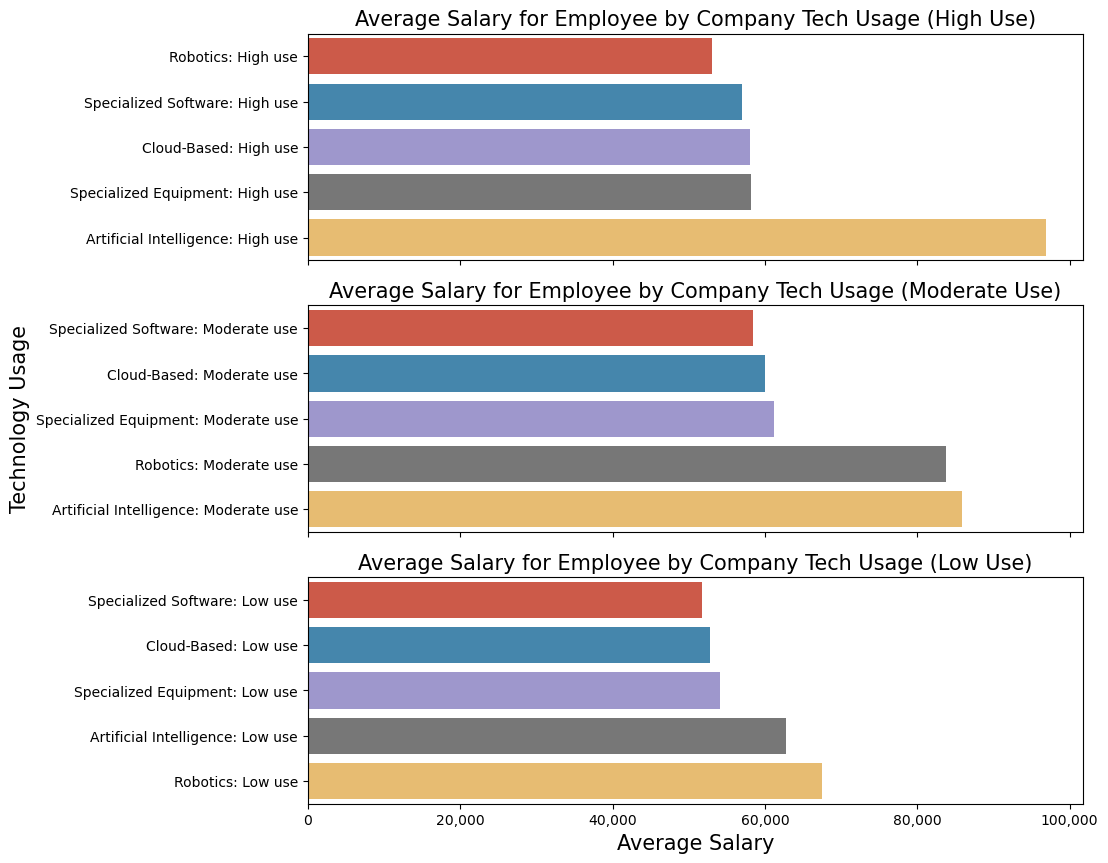

In [13]:
# set up subplots and figure size
figure, axis = plt.subplots(3, sharex=True, figsize=(10, 10))
plt.style.use('ggplot')

# plot the high-use tech data on the first plot
sns.barplot(ax = axis[0], y = techvisual_1_df_High["tech_use"], x = techvisual_1_df_High["avg_salary"])
axis[0].set_title("Average Salary for Employee by Company Tech Usage (High Use)", fontsize = 15)
axis[0].set_xlabel("")
axis[0].set_ylabel("")

# plot the moderate-use tech data on the second plot
sns.barplot(ax = axis[1], y = techvisual_1_df_Mod["tech_use"], x = techvisual_1_df_Mod["avg_salary"])
axis[1].set_title("Average Salary for Employee by Company Tech Usage (Moderate Use)", fontsize = 15)
axis[1].set_xlabel("")
axis[1].set_ylabel("Technology Usage", fontsize = 15)

# plot the low-use tech data on the third plot
sns.barplot(ax = axis[2], y = techvisual_1_df_Low["tech_use"], x = techvisual_1_df_Low["avg_salary"])
axis[2].set_title("Average Salary for Employee by Company Tech Usage (Low Use)", fontsize = 15)
axis[2].set_xlabel("Average Salary", fontsize = 15)
axis[2].set_ylabel("")

# makes sure tick labels appear with commas
current_values = plt.gca().get_xticks();
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values]);

plt.show()

##### What does this visual show?


##### Tech Visual 2
Using the same datasets, we then sorted by the revenue column and graphed the same thing for revenues instead.

In [14]:
# sort each dataframe (high, moderate, low) by revenues
techvisual_1_df_High.sort_values(by = "revenue", inplace= True)
techvisual_1_df_Mod.sort_values(by = "revenue", inplace= True)
techvisual_1_df_Low.sort_values(by = "revenue", inplace= True)

C:\Users\zach3\AppData\Local\Temp\ipykernel_11008\558653268.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values]);


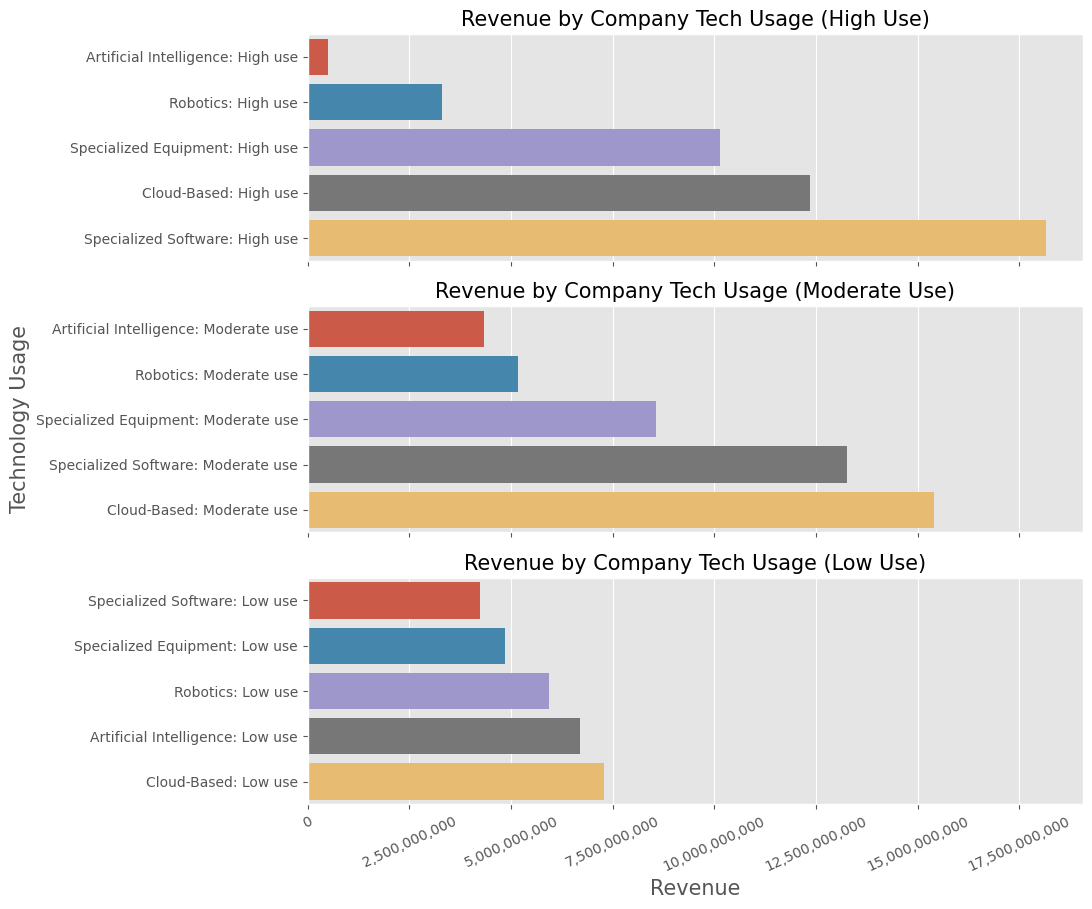

In [15]:
# set up subplots and figure size
figure, axis = plt.subplots(3, sharex=True, figsize=(10, 10))
plt.style.use('ggplot')

# plot the high-use tech data on the first plot
sns.barplot(ax = axis[0], y = techvisual_1_df_High["tech_use"], x = techvisual_1_df_High["revenue"])
axis[0].set_title("Revenue by Company Tech Usage (High Use)", fontsize = 15);
axis[0].set_xlabel("")
axis[0].set_ylabel("");

# plot the moderate-use tech data on the second plot
sns.barplot(ax = axis[1], y = techvisual_1_df_Mod["tech_use"], x = techvisual_1_df_Mod["revenue"])
axis[1].set_title("Revenue by Company Tech Usage (Moderate Use)", fontsize = 15)
axis[1].set_xlabel("")
axis[1].set_ylabel("Technology Usage", fontsize = 15);

# plot the low-use tech data on the third plot
sns.barplot(ax = axis[2], y = techvisual_1_df_Low["tech_use"], x = techvisual_1_df_Low["revenue"])
axis[2].set_title("Revenue by Company Tech Usage (Low Use)", fontsize = 15)
axis[2].set_xlabel("Revenue", fontsize = 15);
axis[2].set_ylabel("");

# make sure tick labels are NOT in scientific notation and have commas
plt.ticklabel_format(style='plain', axis= 'x')
plt.xticks(rotation = 25)
current_values = plt.gca().get_xticks();
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values]);

plt.show();

##### What does this visual show?

##### Tech Visual 3

This visual looks at each type of technology which every single tech-use category compared to average salary. For this visual we created a dataframe for each type of technology (artificial intelligence, cloud-based, specialized software, specialized equipment, and Robotics). Additionally, we created the average salary column within these dataframes using the same method discussed previously.

In [16]:
# get only data where tech_use is about Artificial Intelligence
techvisual_3_df_AI = techvisual_1_df[(techvisual_1_df['tech_use'].str.contains('Artificial Intelligence'))]

# group by tech_use and sum the other columns
techvisual_3_df_AI = techvisual_3_df_AI.groupby(by = "tech_use", as_index=False).sum().sort_values(by = "annual_payroll")

# create average salary column using the number of employes and annual payroll columns
techvisual_3_df_AI["avg_salary"] = (techvisual_3_df_AI["annual_payroll"]/techvisual_3_df_AI["number_of_employees"])*1000

# sort by average salary
techvisual_3_df_AI.sort_values(by = "avg_salary", inplace= True)

In [17]:
# repeat steps for Robotics
techvisual_3_df_Rob = techvisual_1_df[(techvisual_1_df['tech_use'].str.contains('Robotics'))]
techvisual_3_df_Rob = techvisual_3_df_Rob.groupby(by = "tech_use", as_index=False).sum().sort_values(by = "annual_payroll")
techvisual_3_df_Rob["avg_salary"] = (techvisual_3_df_Rob["annual_payroll"]/techvisual_3_df_Rob["number_of_employees"])*1000
techvisual_3_df_Rob.sort_values(by = "avg_salary", inplace= True)

In [18]:
# repeat steps for Specialized Equipment
techvisual_3_df_SE = techvisual_1_df[(techvisual_1_df['tech_use'].str.contains('Specialized Equipment'))]
techvisual_3_df_SE = techvisual_3_df_SE.groupby(by = "tech_use", as_index=False).sum().sort_values(by = "annual_payroll")
techvisual_3_df_SE["avg_salary"] = (techvisual_3_df_SE["annual_payroll"]/techvisual_3_df_SE["number_of_employees"])*1000
techvisual_3_df_SE.sort_values(by = "avg_salary", inplace= True)

In [19]:
# repeat steps for Cloud-Based
techvisual_3_df_CB = techvisual_1_df[(techvisual_1_df['tech_use'].str.contains('Cloud-Based'))]
techvisual_3_df_CB = techvisual_3_df_CB.groupby(by = "tech_use", as_index=False).sum().sort_values(by = "annual_payroll")
techvisual_3_df_CB["avg_salary"] = (techvisual_3_df_CB["annual_payroll"]/techvisual_3_df_CB["number_of_employees"])*1000
techvisual_3_df_CB.sort_values(by = "avg_salary", inplace= True)

In [20]:
# repeat steps for Specialized Software
techvisual_3_df_SS = techvisual_1_df[(techvisual_1_df['tech_use'].str.contains('Specialized Software'))]
techvisual_3_df_SS = techvisual_3_df_SS.groupby(by = "tech_use", as_index=False).sum().sort_values(by = "annual_payroll")
techvisual_3_df_SS["avg_salary"] = (techvisual_3_df_SS["annual_payroll"]/techvisual_3_df_SS["number_of_employees"])*1000
techvisual_3_df_SS.sort_values(by = "avg_salary", inplace= True)

C:\Users\zach3\AppData\Local\Temp\ipykernel_11008\4254745818.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values]);


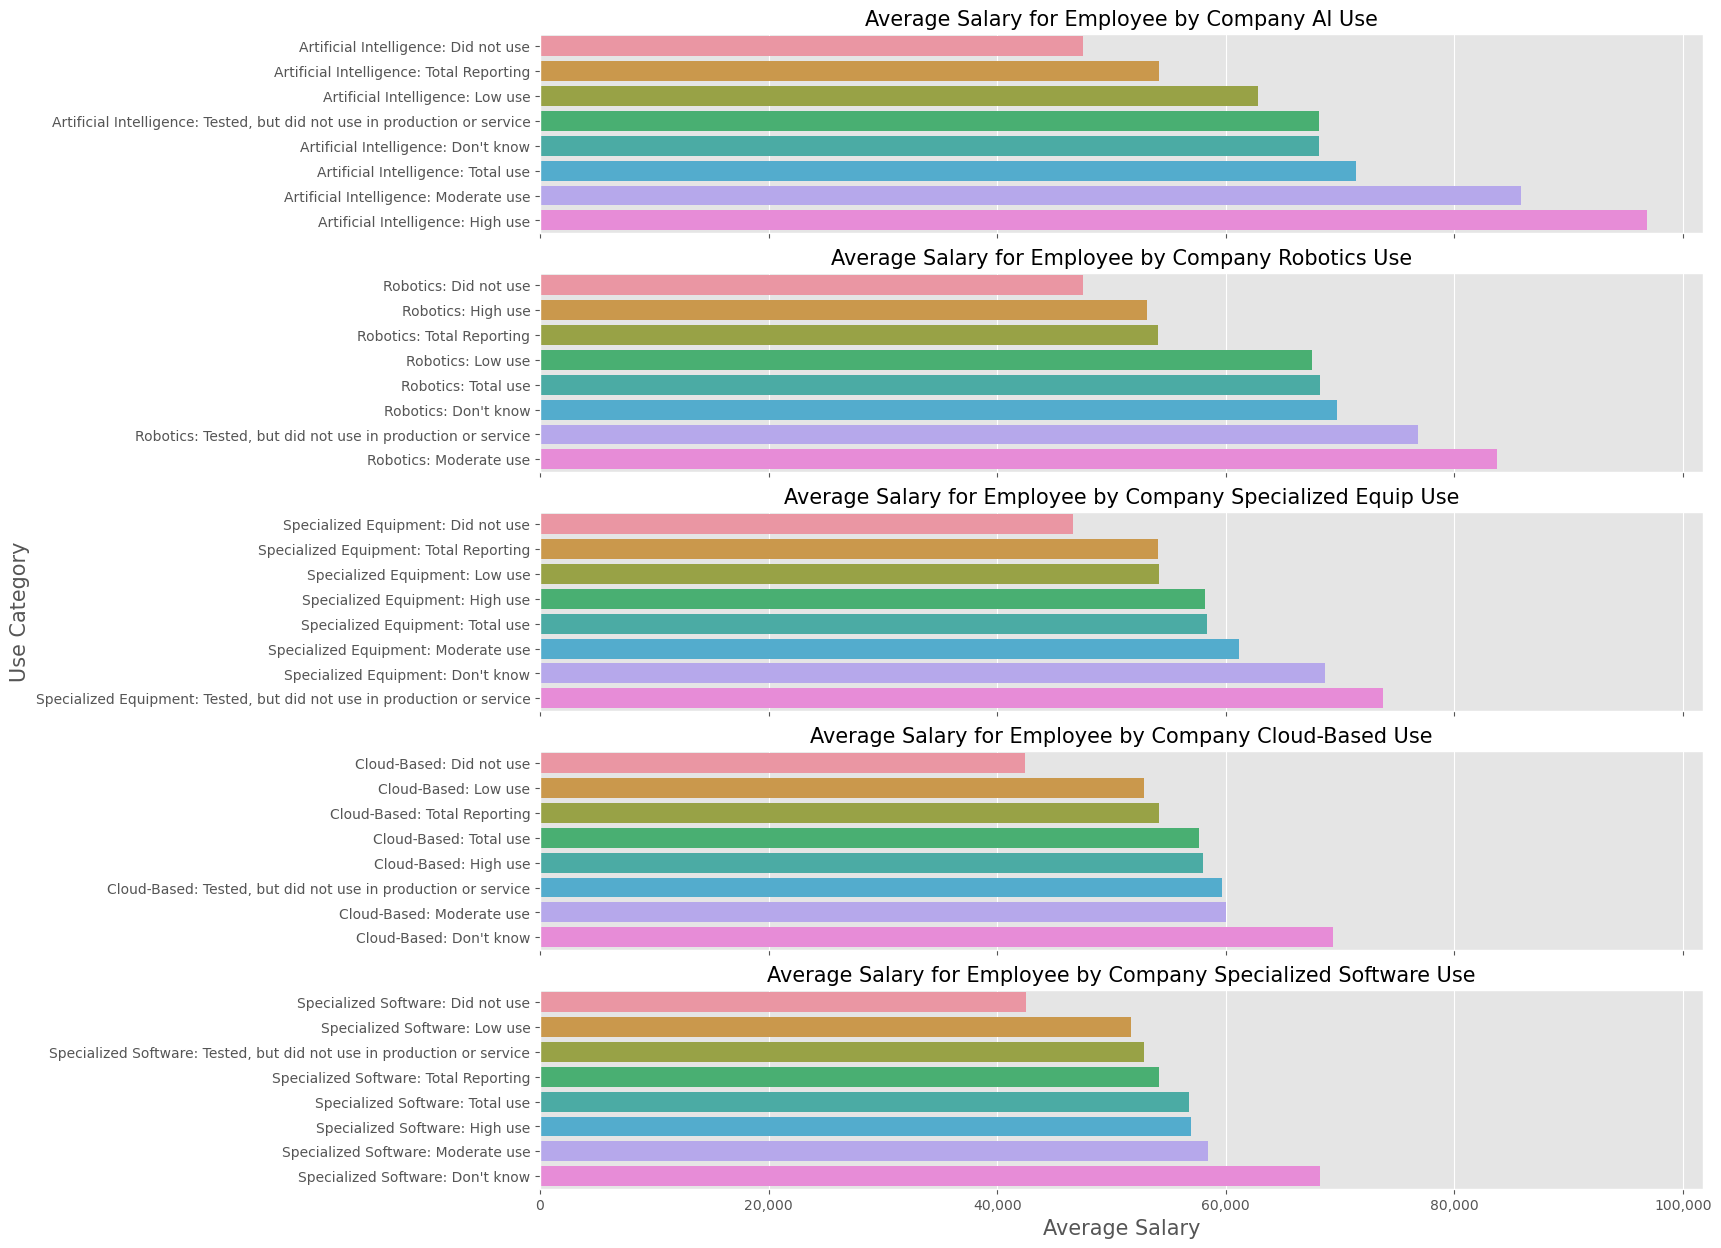

In [21]:
# set up subplots, figure size, and style
figure, axis = plt.subplots(5, sharex=True, figsize=(15, 15))
plt.style.use('ggplot')

# plot the Artificial Intelligence data
sns.barplot(ax = axis[0], y = techvisual_3_df_AI["tech_use"], x = techvisual_3_df_AI["avg_salary"])
axis[0].set_title("Average Salary for Employee by Company AI Use", fontsize=15)
axis[0].set_xlabel("")
axis[0].set_ylabel("");

# plot the Robotics data
sns.barplot(ax = axis[1], y = techvisual_3_df_Rob["tech_use"], x = techvisual_3_df_Rob["avg_salary"])
axis[1].set_title("Average Salary for Employee by Company Robotics Use", fontsize=15)
axis[1].set_xlabel("")
axis[1].set_ylabel("");

# plot the Specialized Equipment data
sns.barplot(ax = axis[2], y = techvisual_3_df_SE["tech_use"], x = techvisual_3_df_SE["avg_salary"])
axis[2].set_title("Average Salary for Employee by Company Specialized Equip Use", fontsize=15)
axis[2].set_xlabel("")
axis[2].set_ylabel("Use Category", fontsize=15);

# plot the Cloud-Based data
sns.barplot(ax = axis[3], y = techvisual_3_df_CB["tech_use"], x = techvisual_3_df_CB["avg_salary"])
axis[3].set_title("Average Salary for Employee by Company Cloud-Based Use", fontsize=15)
axis[3].set_xlabel("")
axis[3].set_ylabel("");

# plot the Specialized Software data
sns.barplot(ax = axis[4], y = techvisual_3_df_SS["tech_use"], x = techvisual_3_df_SS["avg_salary"])
axis[4].set_title("Average Salary for Employee by Company Specialized Software Use", fontsize=15)
axis[4].set_xlabel("Average Salary", fontsize=15)
axis[4].set_ylabel("")

# makes sure tick labels appear with commas
current_values = plt.gca().get_xticks();
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values]);

plt.show();

##### What does this visual show?

### Individual State Dataset

##### Extracting the Data

Using the same method as above we created individual variables to hold each part of the api url. Then using an f-string we combine each part of this string into one final url. This url is then later used to retrieve the data we are trying to obtain.

In [22]:
# each part of the api url gets its own variable
apikey = '&key=240ad37f761e431bc5288cca3370427cb54d59b3'
get = 'get=GEO_ID,NAME,EMP,EMP_F,ETH_GROUP_LABEL,FACTORS_P,FACTORS_P_LABEL,FACTORS_U,FACTORS_U_LABEL,FIRMPDEMP,FIRMPDEMP_F,IMPACTWF_P,IMPACTWF_P_LABEL,IMPACTWF_U,IMPACTWF_U_LABEL,IMPACTWK_P,IMPACTWK_P_LABEL,IMPACTWK_U,IMPACTWK_U_LABEL,MOTPRODTECH,MOTPRODTECH_LABEL,MOTUSETECH,MOTUSETECH_LABEL,NAICS2017_LABEL,NSFSZFI,NSFSZFI_LABEL,PAYANN,RACE_GROUP_LABEL,RCPPDEMP,RCPPDEMP_F,SEX_LABEL,TECHSELL,TECHSELL_LABEL,TECHUSE,TECHUSE_LABEL,VET_GROUP_LABEL'
for_filter = '&for=state:*'
base_url = 'https://api.census.gov/data/2018/abstcb?'

# use an f string to combine each part into the final api call
url = f"{base_url}{get}{for_filter}{apikey}"

We perform a get request using the requests library, then confirm that the get request worked as expected. If it worked as expected, Response 200 should be printed below this code cell.

In [23]:
# perform get request and confirm it worked (looking for <Response [200]>)
r = requests.get(url=url)
print(r)

<Response [200]>


Then we load the data from the get request into a pandas dataframe. We do this by first, taking the get request and then putting it into json format. Since, json format can be read as a dictionary in python, we then use the pd.DataFrame.from_dict method on the json to put the data into a dataframe. Once the data is within the dataframe, the first row displays the column names. We fix this problem and set the columns equal to this first row and then remove the row from the data.

In [24]:
# load get request into json format
r = json.loads(r.text)

# load json into pandas dataframe
data = pd.DataFrame.from_dict(r)

# fix column headers
columns = data.iloc[0]
new_data = data.values[1:]
tech_data_state = pd.DataFrame(new_data, columns=columns)

##### Transforming the Data

(Same steps as the US dataset)

In the next step, we performed our transformations on the data. To begin this section, we decided to keep only specified columns. We dropped the flag columns as they were almost entirely null and not very helpful. Additionally, we opted to keep the label columns instead of the numbered columns (i.e. we keep factors_p_label but not factors_p). We did this so that the labels make more sense to another human who would try look at our data or visuals.

In addition to removing the unnecessary columns, we also needed to change the data types of certain variables. When you read a csv into a dataFrame, the types of the columns tend to get changed into strings even if they should be ints or floats. So for columns like EMP, PAYANN, etc. we need to change their types to ints. This will allow us to perform mathematical operations on these columns and will give us numerical data to use with our visuals.

Then the final transformation on the dataset was to rename all of the column names. This is again specifically helpful to the audience of our data and graphics. This step ensures that the columns more understandable to the average human. Once this step was completed the data was cleaned and ready to be used for visuals.

In [25]:
keep_columns = ['NAME', 'EMP','ETH_GROUP_LABEL', 'FACTORS_P_LABEL', 'FACTORS_U_LABEL', 'FIRMPDEMP', 'IMPACTWF_P_LABEL', 'IMPACTWF_U_LABEL', 'IMPACTWK_P_LABEL', 'IMPACTWK_U_LABEL', 'MOTPRODTECH_LABEL', 'MOTUSETECH_LABEL', 'NAICS2017_LABEL', 'NSFSZFI_LABEL', 'PAYANN', 'RACE_GROUP_LABEL', 'RCPPDEMP', 'SEX_LABEL', 'TECHSELL_LABEL', 'TECHUSE_LABEL', 'VET_GROUP_LABEL']
tech_data_state = tech_data_state[keep_columns]
int_columns = ['EMP', 'FIRMPDEMP', 'PAYANN', 'RCPPDEMP']
tech_data_state[int_columns] = tech_data_state[int_columns].astype('int64')
tech_data_state.rename(columns={
    'NAME'              :'state',
    'EMP'               :'number_of_employees',
    'ETH_GROUP_LABEL'   :'ethnicity_group',
    'FACTORS_P_LABEL'   :'tech_production_factors',
    'FACTORS_U_LABEL'   :'tech_use_factors',
    'FIRMPDEMP'         :'number_of_firms',
    'IMPACTWF_P_LABEL'  :'tech_production_impact_workforce',
    'IMPACTWF_U_LABEL'  :'tech_use_impact_workforce',
    'IMPACTWK_P_LABEL'  :'tech_production_impact_workers',
    'IMPACTWK_U_LABEL'  :'tech_use_impact_workers',
    'MOTPRODTECH_LABEL' :'tech_production_motivation',
    'MOTUSETECH_LABEL'  :'tech_use_motivation',
    'NAICS2017_LABEL'   :'industry',
    'NSFSZFI_LABEL'     :'firm_employment_size',
    'PAYANN'            :'annual_payroll',
    'RACE_GROUP_LABEL'  :'race_group',
    'RCPPDEMP'          :'revenue',
    'SEX_LABEL'         :'sex',
    'TECHSELL_LABEL'    :'tech_production',
    'TECHUSE_LABEL'     :'tech_use',
    'VET_GROUP_LABEL'   :'vetern_group'   
},
inplace=True);

##### Preparing the Data for Visualizations

Now that we were working with a dataset that had state data as well, that became the focus of this final visual. For this visual, we want to show how techuse is related to salary across differing states. In order to do this, we first made a dataframe that included only the neccesary columns. Additionally, we only included rows were tech_use did NOT equal All firms. These are aggregated total columns and are not needed for the visual we are attempting to build.

In [26]:
# create dataframe with only neccesary columns
techvisual_4_df = tech_data_state[:][["state", "number_of_employees", "annual_payroll", "revenue", "tech_use"]]

# only keep rows that are NOT aggregated totals of tech_use
techvisual_4_df = techvisual_4_df[(techvisual_4_df["tech_use"] != "All firms")]


Next since there are already multiple factors at play, we decided to exclusively focus on high-use data only. This means that we will only analyze how salaries differ by state based on the high-use technology data. In the cell below, we begin by creating a dataframe of the high-use technology only. Then we split that data into 5 different dataframes based on which technology the data is based on.

In [27]:
# create a dataframe that contains only high-use tech data
techvisual_4_df_High = techvisual_4_df[(techvisual_4_df['tech_use'].str.contains('High'))]

# group by tech_use and state while summing the other categories
techvisual_4_df_High = techvisual_4_df_High.groupby(by = ["tech_use", "state"], as_index=False)[["annual_payroll", "number_of_employees"]].sum()

# create average salary column, fill any na values with 0 (avoids errors later), and sort the values
techvisual_4_df_High["avg_salary"] = (techvisual_4_df_High["annual_payroll"]/techvisual_4_df_High["number_of_employees"])*1000
techvisual_4_df_High["avg_salary"].fillna(0, inplace=True)
techvisual_4_df_High.sort_values(by = "avg_salary", inplace= True)

# create specific dataframes for each type of technology
techvisual_4_df_High_Rob = techvisual_4_df_High[(techvisual_4_df_High['tech_use'].str.contains('Robotics'))]
techvisual_4_df_High_SE = techvisual_4_df_High[(techvisual_4_df_High['tech_use'].str.contains('Specialized Equipment'))]
techvisual_4_df_High_SS = techvisual_4_df_High[(techvisual_4_df_High['tech_use'].str.contains('Specialized Software'))]
techvisual_4_df_High_CB = techvisual_4_df_High[(techvisual_4_df_High['tech_use'].str.contains('Cloud-Based'))]
techvisual_4_df_High_AI = techvisual_4_df_High[(techvisual_4_df_High['tech_use'].str.contains('Artificial Intelligence'))]


In the next cell, we prepped the data to be merged back together. In this step, for each technology we grab only the columns related to state and average salary. Then, we renamed the average salary column so we can distinguish between them when we merge all the data together.

In [28]:
# grab columns for Artificial Intelligence and rename salary column
techvisual_4_df_High_AI = techvisual_4_df_High_AI[["state", "avg_salary"]]
techvisual_4_df_High_AI.rename(columns = {"avg_salary" : "avg_salary_AI"}, inplace = True)

# grab columns for Robotics and rename salary column
techvisual_4_df_High_Rob = techvisual_4_df_High_Rob[["state", "avg_salary"]]
techvisual_4_df_High_Rob.rename(columns = {"avg_salary" : "avg_salary_Rob"}, inplace = True)

# grab columns for Specialized Software and rename salary column
techvisual_4_df_High_SS = techvisual_4_df_High_SS[["state", "avg_salary"]]
techvisual_4_df_High_SS.rename(columns = {"avg_salary" : "avg_salary_SS"}, inplace = True)

# grab columns for Specialized Equipment and rename salary column
techvisual_4_df_High_SE = techvisual_4_df_High_SE[["state", "avg_salary"]]
techvisual_4_df_High_SE.rename(columns = {"avg_salary" : "avg_salary_SE"}, inplace = True)

# grab columns for Cloud-Based and rename salary column
techvisual_4_df_High_CB = techvisual_4_df_High_CB[["state", "avg_salary"]]
techvisual_4_df_High_CB.rename(columns = {"avg_salary" : "avg_salary_CB"}, inplace = True)

Now we can merge the 5 differing dataframes based on their state columns. This will give us one final dataframe to use to build the visual. The data should have 51 rows (all states + DC) and contain five different salaries based on the differing technologies.

In [29]:
# merge the data related to salaries on the state column of each dataset
techvisual4_df = pd.merge(pd.merge(pd.merge(pd.merge(techvisual_4_df_High_AI, techvisual_4_df_High_Rob, on = "state"), techvisual_4_df_High_SS, on = "state"), techvisual_4_df_High_SE, on = "state"), techvisual_4_df_High_CB, on = "state")

# create a total column by summing the salaries of each row
techvisual4_df["total"] = techvisual4_df["avg_salary_AI"] + techvisual4_df["avg_salary_Rob"] + techvisual4_df["avg_salary_SS"] + techvisual4_df["avg_salary_SE"] + techvisual4_df["avg_salary_CB"]

# sort by total (make the visual look nicer), then drop the column
techvisual4_df.sort_values(by = "total", inplace=True)
techvisual4_df.drop(columns="total", inplace = True)

C:\Users\zach3\AppData\Local\Temp\ipykernel_11008\738614149.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(y) for y in current_values]);


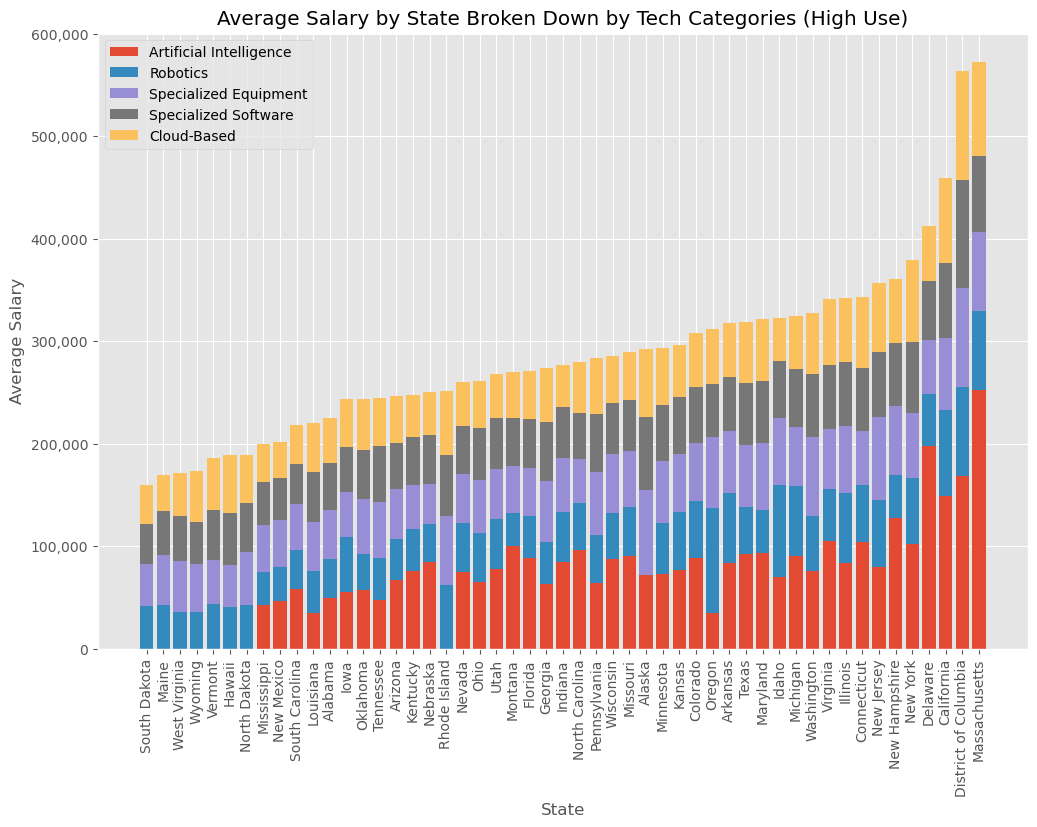

In [30]:
# set figure size and style
plt.style.use('ggplot')
plt.figure(figsize= (12,8))

# plot Artificial Intelligence data
plt.bar(techvisual4_df["state"], techvisual4_df["avg_salary_AI"])

# plot Robotics data starting at end of AI
plt.bar(techvisual4_df["state"], techvisual4_df["avg_salary_Rob"], bottom=techvisual4_df["avg_salary_AI"].values)

# plot Specialized Equipment data starting at end of AI + Robotics
plt.bar(techvisual4_df["state"], techvisual4_df["avg_salary_SE"], bottom=techvisual4_df["avg_salary_AI"].values+techvisual4_df["avg_salary_Rob"].values)

# plot Specialized Software data starting at end of AI + Robotics + SE
plt.bar(techvisual4_df["state"], techvisual4_df["avg_salary_SS"], bottom=techvisual4_df["avg_salary_AI"].values+techvisual4_df["avg_salary_Rob"].values+techvisual4_df["avg_salary_SE"].values)

# plot Cloud Based data starting at end of AI + Robotics + SE + SS
plt.bar(techvisual4_df["state"], techvisual4_df["avg_salary_CB"], bottom=techvisual4_df["avg_salary_AI"].values+techvisual4_df["avg_salary_Rob"].values+techvisual4_df["avg_salary_SE"].values+techvisual4_df["avg_salary_SS"].values)

# label and format graph
plt.xlabel("State")
plt.ylabel("Average Salary")
plt.legend(["Artificial Intelligence", "Robotics", "Specialized Equipment", "Specialized Software", "Cloud-Based"])
plt.title("Average Salary by State Broken Down by Tech Categories (High Use)")

# fix the tick labels and formatting
plt.xticks(rotation = 90)
current_values = plt.gca().get_yticks();
plt.gca().set_yticklabels(['{:,.0f}'.format(y) for y in current_values]);

plt.show();

##### What does this visual show?